# <font color=blue> __InferPloidy Application Example__  </font>
MLBI-lab@DKU, May 20, 2025

In [ ]:
## Required python packages
'''
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn

'''
!pip install scikit-network
!pip install scanpy
!pip install hicat
!pip install infercnvpy
!pip install inferploidy
!pip install scoda-viz
!pip install gdown

In [15]:
## Import required packages
import copy, warnings, os, random
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from hicat import get_hicat_markers_db, run_hicat
from inferploidy import run_inferploidy, run_infercnv
from scodaviz import plot_cnv, plot_marker_exp, load_sample_data

warnings.filterwarnings('ignore')

### __Load data__

In [16]:
data = 'BRCA' # 'BRCA', 'NSCLC', 'PDAC', 'CRC'
tissue = 'Breast' # 'Breast', 'Lung', 'Pancreas', 'Intestine'

adata = load_sample_data( data )
adata

Downloading...
From (original): https://drive.google.com/uc?export=download&id=158LUiHiJNFzYvqY-QzMUm5cvIznBrUAV
From (redirected): https://drive.google.com/uc?export=download&id=158LUiHiJNFzYvqY-QzMUm5cvIznBrUAV&confirm=t&uuid=ee37cbb7-aeb8-48a3-bb49-c14b19e4821d
To: /mnt/HDD2/Google_drive/git/downloaded
100%|██████████████████████████████████████████████████████████████████████████████████████| 124M/124M [00:13<00:00, 9.48MB/s]


File saved to: BRCA.h5ad


AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'sid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'subtype_detail', 'tissue', 'condition', 'sample', 'copykat_dec', 'scevan_dec'

### __Run HiCAT for celltype annotation__

In [17]:
## Run HiCAT to annotate cell-type
## The cell-type annotation will be used to collect reference cells for inferCNV and InferPloidy
mkr_db = get_hicat_markers_db( species = 'hs', tissue = tissue )
adata = run_hicat( adata, mkr_db = mkr_db, species = 'hs',
                   n_pca_comp = 15, clustering_resolution = 2,
                   verbose = True )
adata

Celltype annotation (using HiCAT) ..  
   HiCAT preprocessing 
   HiCAT major type identification 
   HiCAT minor type identification
   HiCAT subset identification


AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'sid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'subtype_detail', 'tissue', 'condition', 'sample', 'copykat_dec', 'scevan_dec', 'celltype_major', 'celltype_minor', 'celltype_subset'
    uns: 'subset_markers'

Num markers selected: 167 -> 120


... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'celltype_subset' as categorical


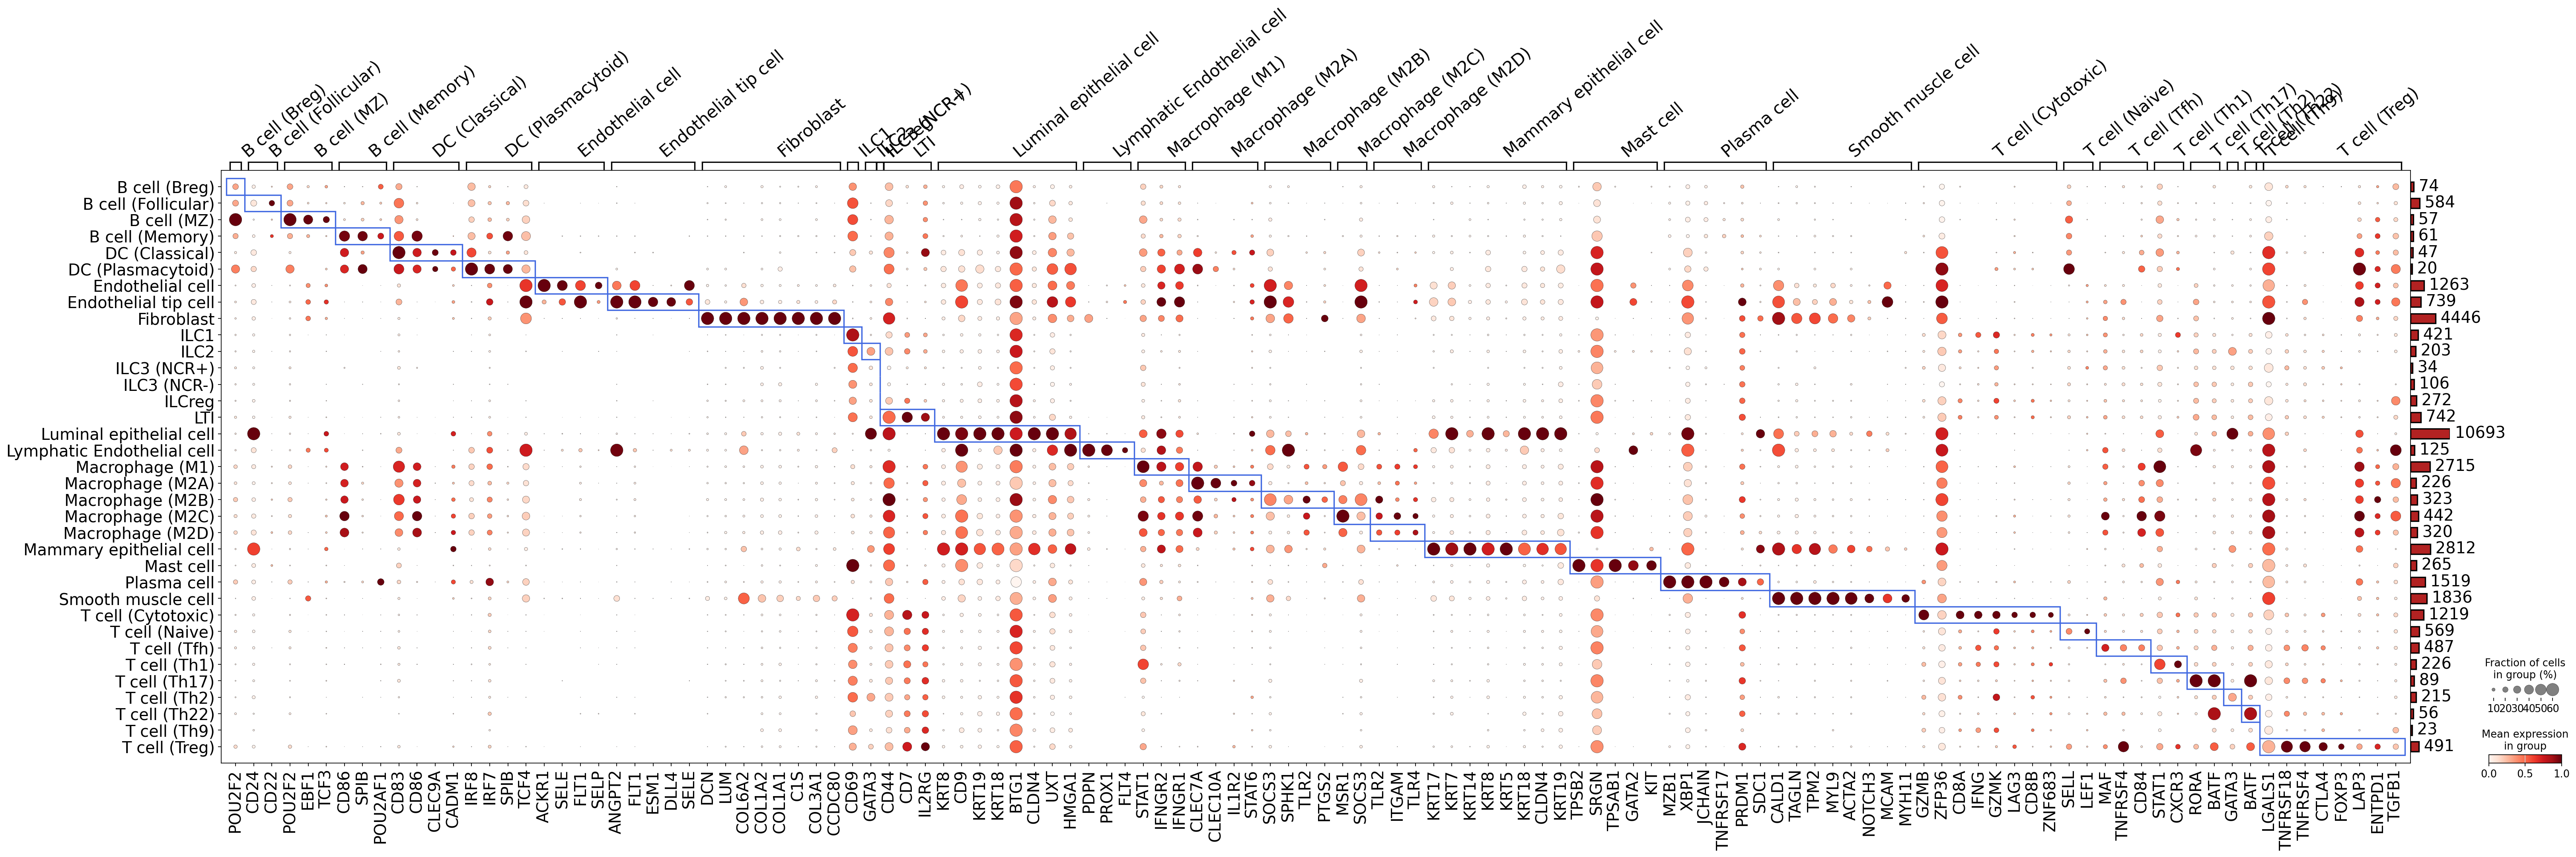

In [18]:
mkr_dict = copy.deepcopy( adata.uns['subset_markers'] )
var_group_col = 'celltype_subset'

plot_marker_exp(  adata, markers = mkr_dict,
                  var_group_col = var_group_col, group_col = None,
                  title = None, title_y_pos = 1.1, title_fs = 30,
                  text_fs = 18, linewidth = 1.5, standard_scale = 'var',
                  var_group_rotation = 40, var_group_height = 1.2,
                  nz_frac_max = 0.6, nz_frac_cutoff = 0.05,
                  rem_mkrs_common_in_N_groups_or_more = 3, N_cells_min = 20,
                  N_markers_per_group_max = 8, N_markers_total = 120,
                  figsize = None, swap_ax = False, legend = True )


In [19]:
adata.obs['celltype_major'].value_counts()

celltype_major
Epithelial cell       13505
T cell                 5162
Fibroblast             4446
Myeloid cell           4106
B cell                 2295
Endothelial cell       2127
Smooth muscle cell     1836
Mast cell               265
Name: count, dtype: int64

### __Run InferCNV and InferPloidy__

In [20]:
ref_key = 'celltype_major'
ref_cat = ['T cell', 'B cell', 'Myeloid cell', 'Fibroblast']

run_infercnv(adata, ref_key = ref_key, ref_cat = ref_cat,
             gtf_file = None, species = 'hs',
             window_size = 100, n_cores = 4 )

  0%|          | 0/7 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'sid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'subtype_detail', 'tissue', 'condition', 'sample', 'copykat_dec', 'scevan_dec', 'celltype_major', 'celltype_minor', 'celltype_subset', 'cnv_ref_ind'
    var: 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'subset_markers', 'cnv'
    obsm: 'X_cnv'

In [21]:
adata = run_inferploidy( adata, ref_key = ref_key, ref_cat = ref_cat,
                         N_runs = 7, n_cores = 4, verbose = True,
                         clustering_resolution = 6 )
adata

InferPloidy .. 
   1/7
   2/7
   3/7
   4/7
   5/7
   6/7
   7/7
InferPloidy .. done. (566) 


AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'sid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'subtype_detail', 'tissue', 'condition', 'sample', 'copykat_dec', 'scevan_dec', 'celltype_major', 'celltype_minor', 'celltype_subset', 'cnv_ref_ind', 'iploidy_score', 'iploidy_dec', 'iploidy_init_group'
    var: 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'subset_markers', 'cnv'
    obsm: 'X_cnv', 'X_cnv_pca'

### __Check out CNV pattern__

... storing 'deg_group' as categorical
... storing 'chr' as categorical


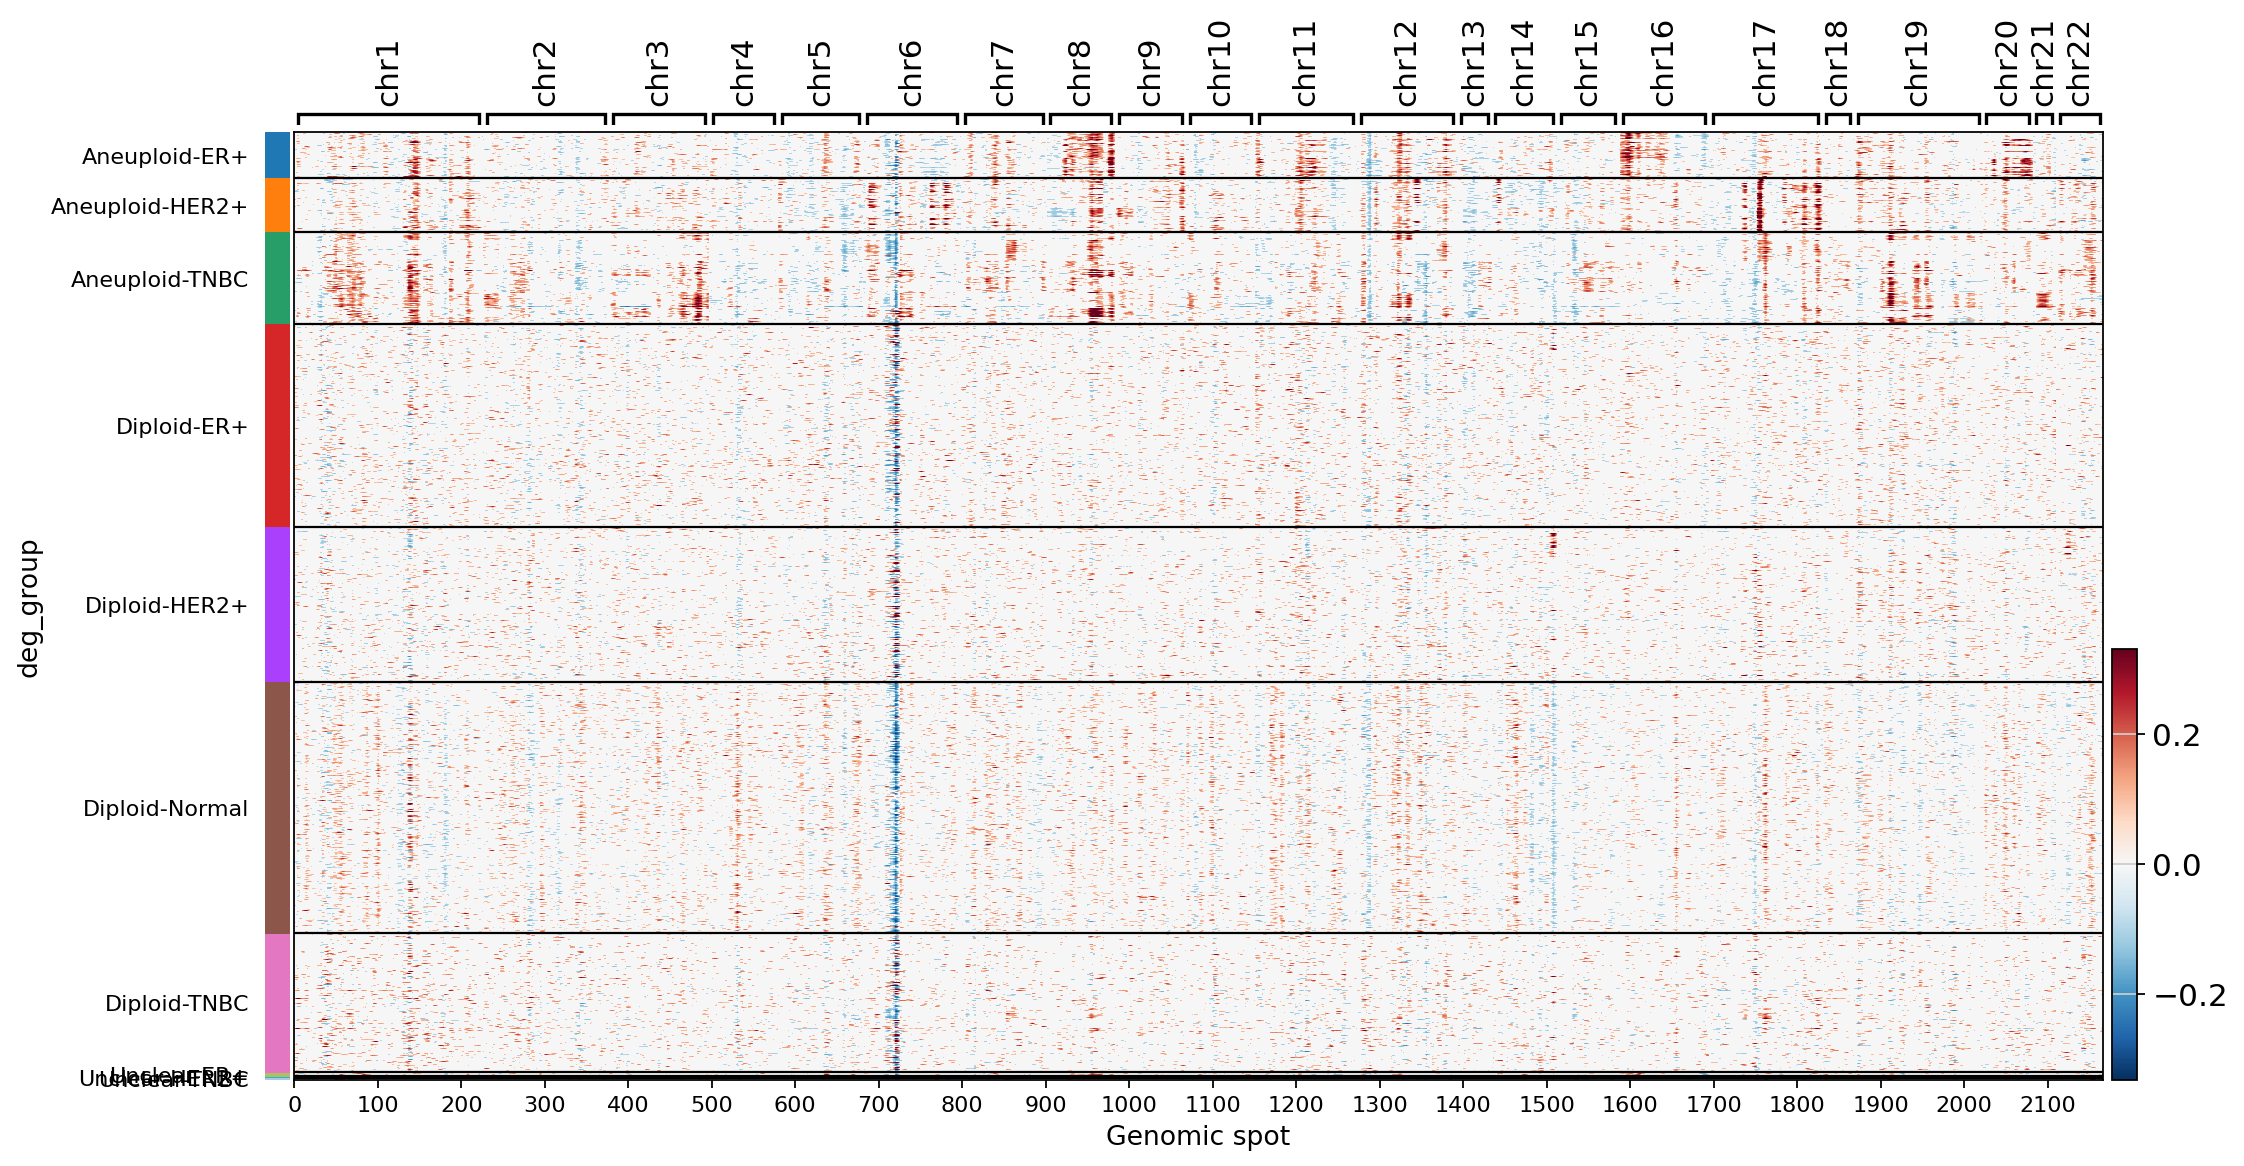

In [28]:
adata_s = adata[:,:]

lst1 = list(adata_s.obs['iploidy_dec'])
lst2 = list(adata_s.obs['condition'])
deg_grouping = 'deg_group'
adata_s.obs[deg_grouping] = ['%s-%s' % (a1, a2) for a1, a2 in zip(lst1, lst2)]

## Select samples with the number of cells >= min.value
pcnt = adata_s.obs[deg_grouping].value_counts()
bp = pcnt >= 50
b = adata_s.obs[deg_grouping].isin(list(pcnt.index.values[bp]))
adata_s = adata_s[b,:]

## Plot CNV patterns of cell groups
axd = plot_cnv( adata_s, groupby = deg_grouping,
                title = '',
                title_fs = 15, title_y_pos = 1.11,
                label_fs = 12, tick_fs = 10,
                figsize = (15, 8), swap_axes = False,
                var_group_rotation = 90, cmap='RdBu_r', vmax = 1,
                cnv_obsm_key = 'X_cnv', cnv_uns_key = 'cnv')


In [23]:
## Perform UMAP projection of CNV patterns
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10, use_rep = 'X_cnv_pca', key_added = 'cnv_neighbors')
ad_tmp = sc.tl.umap(adata, neighbors_key = 'cnv_neighbors', copy = True)
adata.obsm['X_cnv_umap'] = ad_tmp.obsm['X_umap']

... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'celltype_subset' as categorical
... storing 'iploidy_dec' as categorical
... storing 'iploidy_init_group' as categorical
... storing 'chromosome' as categorical
... storing 'gene_id' as categorical
... storing 'gene_name' as categorical


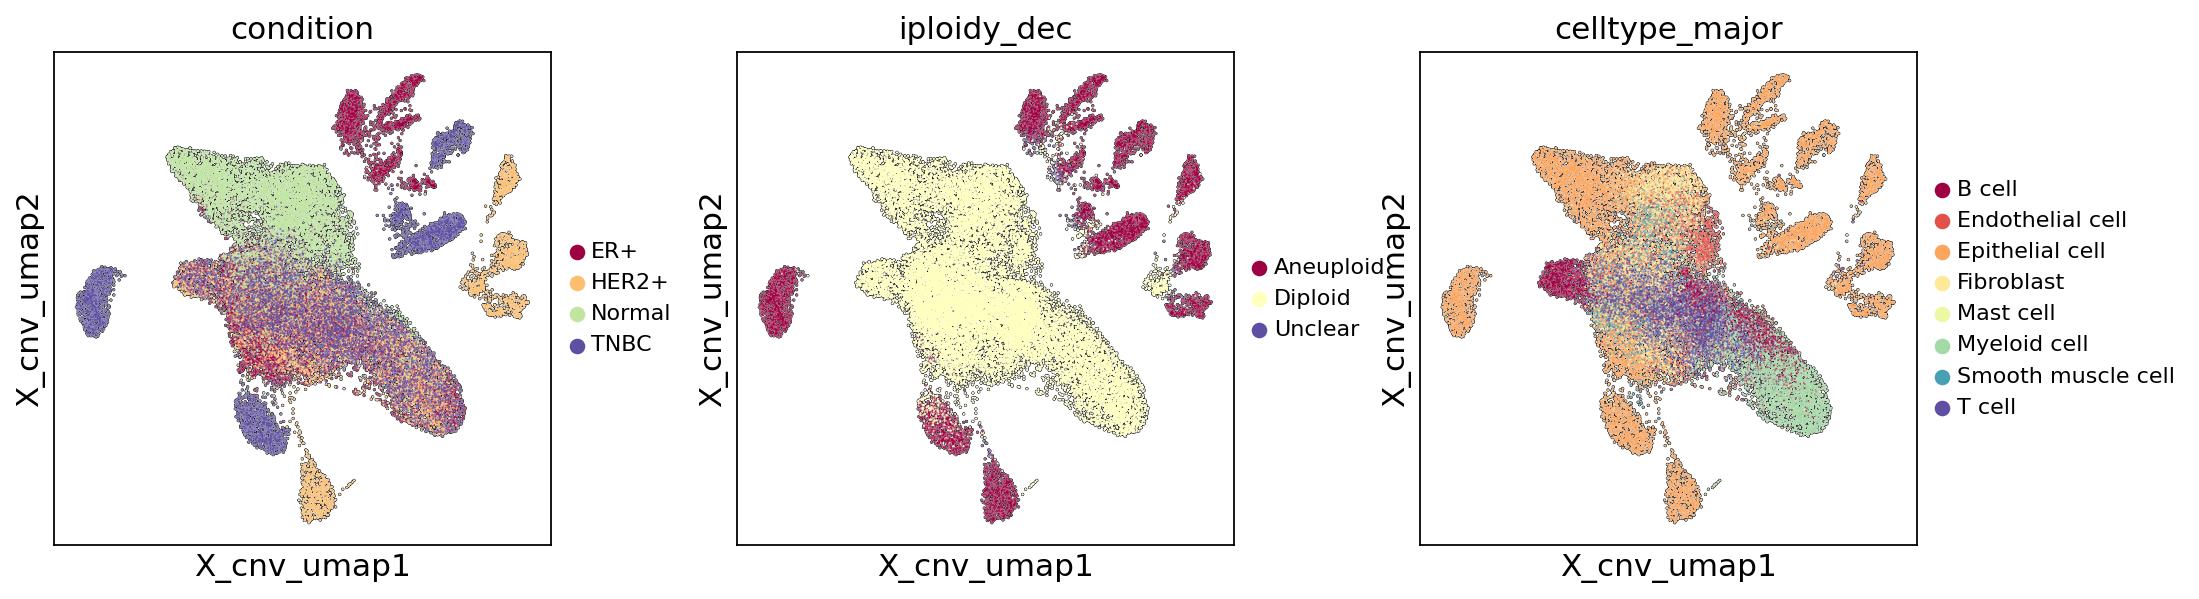

In [24]:
items_to_plot = ['condition', 'iploidy_dec', 'celltype_major']

plt.rcParams['figure.figsize'] = (4, 4)
fig = sc.pl.embedding( adata, basis = 'X_cnv_umap', neighbors_key = 'cnv_neighbors',
                       color=items_to_plot, wspace = 0.25, legend_fontsize = 10,
                       ncols = 3, palette = 'Spectral', return_fig = False,
                       add_outline = True, s = 3)